### 05 - Ajuste fino em redes pré-treinadas 

Nesse código iremos explorar o uso de uma rede cujos pesos foram pré-treinados na base de dados de imagens ImageNet. Será simulada a criação de um conjunto baseado na Cifar-10 com poucos exemplos de treinamento, e comparado o uso de ajuste-fino de uma rede pré-treinada com o treinamento do zero da mesma arquitetura.

A arquitetura utilizada será a MobileNetV2, em sua versão que recebe por entrada imagens de tamanho $128\times 128$. Para que possamos utilizar as imagens da Cifar-10, será necessário redimensioná-las, o que também será demonstrado.

**Moacir A. Ponti 2019**

In [0]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator

from keras import models
from keras import layers
from keras import optimizers
from keras import utils as np_utils

from keras.datasets import cifar10

from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt

import h5py

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# simulando uma base de dados menor,
# amostrando exemplos para finetuning, e 2 vezes esse número pra teste
n = 1000
idx_1 = np.random.choice(x_train.shape[0], n, replace=False)  
idx_2 = np.random.choice(x_test.shape[0], int(n*2), replace=False)  
x_train = x_train[idx_1]
y_train = y_train[idx_1]

x_test = x_test[idx_2]
y_test = y_test[idx_2]

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [18]:
image_size = 128
input_shape=(image_size, image_size, 3)

### para redimensionar a entrada
print("Redimensionando imagens para ", str(input_shape))
x_train_new = np.array([resize(image, input_shape) for image in x_train])
x_test_new = np.array([resize(image, input_shape) for image in x_test])

# cria arquivo para nao precisar redimensionar todas as vezes
#h5f = h5py.File('cifar10_160.h5', 'w')
#h5f.create_dataset('train', data=x_train_new)
#h5f.create_dataset('test', data=x_test_new)
#h5f.close()

Redimensionando imagens para  (128, 128, 3)


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [19]:
print(np.array(x_train_new).shape)
print(np.array(x_test_new).shape)

(1000, 128, 128, 3)
(2000, 128, 128, 3)


In [20]:
print("Baixando pesos da rede pre-treinados na Imagenet")
ptmodel = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

Baixando pesos da rede pre-treinados na Imagenet


In [21]:
# Congelar os pesos das camadas, exceto as últimas k
k = 3
for layer in ptmodel.layers[:-k]:
    layer.trainable = False
 
# Verificar o status de cada camada (descomentar para visualizar)
for layer in ptmodel.layers:
    if (layer.trainable == True):
        print(layer, layer.trainable)

<keras.layers.convolutional.Conv2D object at 0x7f6692efe908> True
<keras.layers.normalization.BatchNormalization object at 0x7f6692e317b8> True
<keras.layers.advanced_activations.ReLU object at 0x7f6692d60e48> True


In [22]:
# create new model
ftmodel = models.Sequential()

# add the pretrained MobileNet base 
ftmodel.add(ptmodel)

# add new layers
ftmodel.add(layers.Flatten())
ftmodel.add(layers.Dense(32, activation='relu'))
ftmodel.add(layers.Dropout(0.5))
ftmodel.add(layers.Dense(10, activation='softmax'))

ftmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten_4 (Flatten)          (None, 20480)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                655392    
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                330       
Total params: 2,913,706
Trainable params: 1,067,882
Non-trainable params: 1,845,824
_________________________________________________________________


In [0]:
ftmodel.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.00025),
              metrics=['acc'])

In [24]:
epochs = 8
batch_size = 32

historyft = ftmodel.fit(x_train_new, y_train,
      epochs=epochs,
      batch_size=batch_size,
      verbose=1,
      validation_data=(x_test_new, y_test))


Train on 1000 samples, validate on 2000 samples
Epoch 1/8
1000/1000 [==============================] - 130s 130ms/step - loss: 2.3428 - acc: 0.1720 - val_loss: 2.2018 - val_acc: 0.1885
Epoch 2/8
1000/1000 [==============================] - 120s 120ms/step - loss: 1.8166 - acc: 0.3150 - val_loss: 2.0051 - val_acc: 0.2675
Epoch 3/8
1000/1000 [==============================] - 117s 117ms/step - loss: 1.5875 - acc: 0.4090 - val_loss: 1.8891 - val_acc: 0.3415
Epoch 4/8
1000/1000 [==============================] - 117s 117ms/step - loss: 1.3798 - acc: 0.4790 - val_loss: 1.9455 - val_acc: 0.3145
Epoch 5/8
1000/1000 [==============================] - 118s 118ms/step - loss: 1.2516 - acc: 0.5320 - val_loss: 1.9379 - val_acc: 0.3390
Epoch 6/8
1000/1000 [==============================] - 117s 117ms/step - loss: 1.0790 - acc: 0.6060 - val_loss: 1.8432 - val_acc: 0.3960
Epoch 7/8
1000/1000 [==============================] - 117s 117ms/step - loss: 0.9712 - acc: 0.6410 - val_loss: 1.8186 - val_acc: 

In [25]:
# inicializa rede Mobilenet
print("Pesos da rede aleatorios")
rdmodel = MobileNetV2(weights=None, include_top=False, input_shape=input_shape)

# create new model
trmodel = models.Sequential()

# add the pretrained MobileNet base 
trmodel.add(rdmodel)

# add new layers
trmodel.add(layers.Flatten())
ftmodel.add(layers.Dropout(0.1))
trmodel.add(layers.Dense(32, activation='relu'))
trmodel.add(layers.Dropout(0.5))
trmodel.add(layers.Dense(10, activation='softmax'))

trmodel.summary()

trmodel.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0005),
              metrics=['acc'])

historytr = trmodel.fit(x_train_new, y_train,
      epochs=epochs,
      batch_size=batch_size,
      verbose=1,
      validation_data=(x_test_new, y_test))

Pesos da rede aleatorios
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten_5 (Flatten)          (None, 20480)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                655392    
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                330       
Total params: 2,913,706
Trainable params: 2,879,594
Non-trainable params: 34,112
_________________________________________________________________
Train on 1000 samples, validate on 2000 samples
Epoch 1/8
1000/1000 [==============================] -

Pre-treinado:
-Teste loss: 1.9664
-Teste accuracia: 0.3730
Aleatorio:
-Teste loss: 2.3026
-Teste accuracia: 0.1020


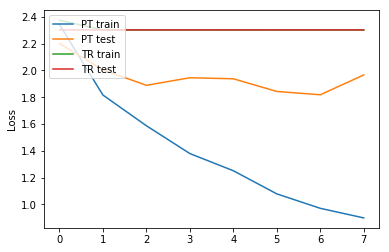

In [26]:
metricspt = ftmodel.evaluate(x_test_new, y_test, verbose=0)
y_hat = ftmodel.predict(x_test_new)

metricstr = trmodel.evaluate(x_test_new, y_test, verbose=0)
y_hattr = trmodel.predict(x_test_new)

# cada métrica é armazenada em uma posicao do vetor
print('Pre-treinado:')
print('-Teste loss: %.4f' % (metricspt[0]))
print('-Teste accuracia: %.4f' % (metricspt[1]))

print('Aleatorio:')
print('-Teste loss: %.4f' % (metricstr[0]))
print('-Teste accuracia: %.4f' % (metricstr[1]))

# utilizando o histórico: o gráfico da função de custo ao longo das épocas
plt.plot(historyft.history['loss'])
plt.plot(historyft.history['val_loss'])
plt.plot(historytr.history['loss'])
plt.plot(historytr.history['val_loss'])
plt.ylabel('Loss')
plt.legend(['PT train', 'PT test','TR train', 'TR test'], loc='upper left')
plt.show()

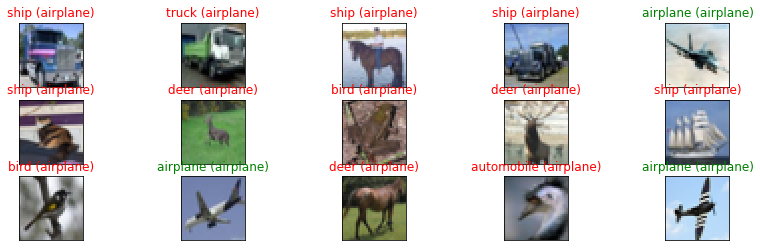

In [28]:
cifar10_labels = ["airplane", "automobile", "bird", "cat", "deer", 
                  "dog", "frog", "horse", "ship", "truck"]

# mude aqui para o dataset desejado
use_labels = cifar10_labels

figure = plt.figure(figsize=(14, 4))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # exibe cada imagem
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(y_hat[index])
    train_index = np.argmax(y_hattr[index])
    # exibe o titulo em verde (correto) e vermelho (incorreto)
    ax.set_title("{} ({})".format(use_labels[predict_index], 
                                  use_labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))